In [1]:
# Core libraries
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Statistical modeling and time series
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

# Machine Learning
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# Statistical utilities
from scipy.stats import zscore

# Dynamic time warping for time series
from tslearn.metrics import dtw

In [2]:
# PREPROCESSING

print("\nLoading datasets...")

# Load the datasets
sp500_index = pd.read_csv('sp500_index.csv')
sp500_stocks = pd.read_csv('sp500_stocks.csv')
sp500_companies = pd.read_csv('sp500_companies.csv')

# Parse date columns
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'])
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])


Loading datasets...


In [3]:
# check for missing values
print(sp500_stocks.isnull().sum())

# select only numeric columns for imputation
numeric_columns = sp500_stocks.select_dtypes(include=[np.number]).columns

# fill missing values for numeric columns with the median
sp500_stocks[numeric_columns] = sp500_stocks[numeric_columns].fillna(sp500_stocks[numeric_columns].median())

# verify that there are no more missing values in the numeric columns
print(sp500_stocks[numeric_columns].isnull().sum())


Date             0
Symbol           0
Adj Close    88780
Close        88780
High         88780
Low          88780
Open         88780
Volume       88780
dtype: int64
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


In [4]:
# handle missing values for categorical columns
categorical_columns = sp500_stocks.select_dtypes(include=['object']).columns
sp500_stocks[categorical_columns] = sp500_stocks[categorical_columns].fillna('Unknown')

In [5]:
from sklearn.preprocessing import StandardScaler

sp500_stocks['Price Change'] = sp500_stocks['Close'] - sp500_stocks['Open']
sp500_stocks['Pct Change'] = ((sp500_stocks['Close'] - sp500_stocks['Open']) / sp500_stocks['Open']) * 100
sp500_stocks['Volatility'] = sp500_stocks['High'] - sp500_stocks['Low']

# select numerical features for clustering
clustering_features = sp500_stocks[['Open', 'High', 'Low', 'Volume', 'Price Change', 'Pct Change', 'Volatility']]

numeric_columns = sp500_stocks.select_dtypes(include=[np.number]).columns
clustering_features = sp500_stocks[numeric_columns]

# standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# check the scaled features
scaled_features[:5]  # Display the first 5 scaled rows

array([[-0.27114035, -0.16510088, -0.16698204, -0.16259932, -0.16475899,
        -0.10752494, -0.02248515, -0.07361241, -0.29593839],
       [-0.27243788, -0.16730547, -0.16790394, -0.166762  , -0.16598893,
        -0.11970073, -0.07703169, -0.24966863, -0.18262947],
       [-0.26951838, -0.16234519, -0.162163  , -0.15899448, -0.16140849,
         0.0301909 , -0.05569003, -0.17879106, -0.24910475],
       [-0.2693686 , -0.1620908 , -0.16568298, -0.16495959, -0.16378354,
        -0.01923029,  0.09135149,  0.29127717, -0.16601099],
       [-0.26789632, -0.15958946, -0.16333634, -0.15989571, -0.16221433,
        -0.08511081,  0.14352626,  0.45633311, -0.25967965]])

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

In [7]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# # elbow method to find the optimal number of clusters
# inertia = []
# k_range = range(1, 11)
# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Explicitly set n_init
#     kmeans.fit(scaled_features)
#     inertia.append(kmeans.inertia_)

In [8]:
# # plotting the elbow curve
# plt.figure(figsize=(8, 5))
# plt.plot(k_range, inertia, 'bo-', markersize=8)
# plt.title('Elbow Method for Optimal Number of Clusters')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia')
# plt.grid(True)
# plt.show()

In [9]:
# # apply KMeans clustering with the optimal number of clusters
# kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
# kmeans.fit(scaled_features)

# # add the cluster labels to the original DataFrame
# sp500_stocks['Cluster'] = kmeans.labels_

# # display the first few rows with the cluster labels
# sp500_stocks.head()

In [10]:
# from sklearn.decomposition import PCA

# # Perform PCA to reduce to 2 dimensions for visualization
# pca = PCA(n_components=2)
# principal_components = pca.fit_transform(scaled_features)

# # Plot the clusters after PCA transformation
# plt.figure(figsize=(10, 7))
# plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_, cmap='plasma', s=5)
# plt.title('K-Means Clustering After PCA')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.grid(True)
# plt.show()

In [11]:
# from sklearn.metrics import davies_bouldin_score

# # Compute Davies-Bouldin index
# db_score = davies_bouldin_score(scaled_features, kmeans.labels_)
# print(f'Davies-Bouldin Index: {db_score:.3f}')

In [12]:
# Clean sp500_stocks
relevant_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
sp500_stocks_cleaned = sp500_stocks.dropna(subset=relevant_columns, how='all')

# Compute daily returns
sp500_stocks_cleaned['Return'] = sp500_stocks_cleaned.groupby('Symbol')['Close'].pct_change()

# Drop rows with NaN values in 'Return' and 'Volume'
sp500_stocks_cleaned = sp500_stocks_cleaned[['Return', 'Volume']].dropna()

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load datasets
sp500_stocks = pd.read_csv("sp500_stocks.csv")
sp500_index = pd.read_csv("sp500_index.csv")

# Preprocess the sp500_stocks dataset
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])
sp500_stocks['Close'] = sp500_stocks['Close'].ffill()  # Forward-fill missing Close prices
sp500_stocks['Return'] = sp500_stocks.groupby('Symbol')['Close'].pct_change()  # Calculate daily returns

# Aggregate stock data to daily level
daily_aggregated = sp500_stocks.groupby('Date').agg({
    'Volume': 'sum',            # Sum of trading volumes
    'Return': 'mean',           # Average return across stocks
    'Close': 'mean'             # Average closing price
}).reset_index()

# Calculate additional features
daily_aggregated['Volatility'] = sp500_stocks.groupby('Date')['Return'].std().values  # Daily return volatility
daily_aggregated['5Day_MA'] = daily_aggregated['Close'].rolling(window=5).mean()      # 5-day moving average
daily_aggregated['Momentum'] = daily_aggregated['Return'].rolling(window=5).sum()    # 5-day momentum

# Merge with the sp500_index dataset
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'])
merged_data = pd.merge(sp500_index, daily_aggregated, on='Date', how='inner')

# Define features (X) and target variable (y)
X = merged_data[['Volume', 'Return', 'Volatility', '5Day_MA', 'Momentum']]  # Enhanced feature set
y = (merged_data['S&P500'].shift(-1) > merged_data['S&P500']).astype(int)  # Target: 1 if index increases

# Drop the last row to align with the shifted target variable
X = X[:-1]
y = y[:-1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for k-NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train k-NN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Make Predictions
y_pred = knn.predict(X_test_scaled)

# Evaluate the model
print("k-NN Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report (k-NN):")
print(classification_report(y_test, y_pred))

# Cross-Validation
cv_scores_knn = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nAverage CV Accuracy (k-NN): {np.mean(cv_scores_knn):.4f}")

# Experiment with different values of k
print("\nTesting different values of k for k-NN:")
for k in range(1, 11):
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_temp, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"k={k}, Cross-Validation Accuracy: {np.mean(scores):.4f}")


k-NN Accuracy: 0.4781746031746032

Classification Report (k-NN):
              precision    recall  f1-score   support

           0       0.44      0.35      0.39       240
           1       0.50      0.59      0.54       264

    accuracy                           0.48       504
   macro avg       0.47      0.47      0.47       504
weighted avg       0.47      0.48      0.47       504


Average CV Accuracy (k-NN): 0.4888

Testing different values of k for k-NN:
k=1, Cross-Validation Accuracy: 0.4774
k=2, Cross-Validation Accuracy: 0.4804
k=3, Cross-Validation Accuracy: 0.4928
k=4, Cross-Validation Accuracy: 0.4734
k=5, Cross-Validation Accuracy: 0.4888
k=6, Cross-Validation Accuracy: 0.4769
k=7, Cross-Validation Accuracy: 0.4898
k=8, Cross-Validation Accuracy: 0.4779
k=9, Cross-Validation Accuracy: 0.4988
k=10, Cross-Validation Accuracy: 0.4819


In [14]:
# Fix for FutureWarning
sp500_stocks['Close'] = sp500_stocks['Close'].ffill()  # Forward-fill missing Close prices

# Example: Testing Logistic Regression for comparison
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

# Example: Testing Random Forest for comparison
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Grid Search for Optimal k in k-NN
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 21)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("\nBest k for k-NN:", grid_search.best_params_)
print("Best Cross-Validation Accuracy for k-NN:", grid_search.best_score_)



Logistic Regression Accuracy: 0.5396825396825397

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.07      0.12       240
           1       0.53      0.97      0.69       264

    accuracy                           0.54       504
   macro avg       0.60      0.52      0.40       504
weighted avg       0.60      0.54      0.42       504


Random Forest Accuracy: 0.5059523809523809

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.48      0.40      0.43       240
           1       0.52      0.61      0.56       264

    accuracy                           0.51       504
   macro avg       0.50      0.50      0.50       504
weighted avg       0.50      0.51      0.50       504


Best k for k-NN: {'n_neighbors': 15}
Best Cross-Validation Accuracy for k-NN: 0.5161549572238066


Random Forest AUC-ROC: 0.5009


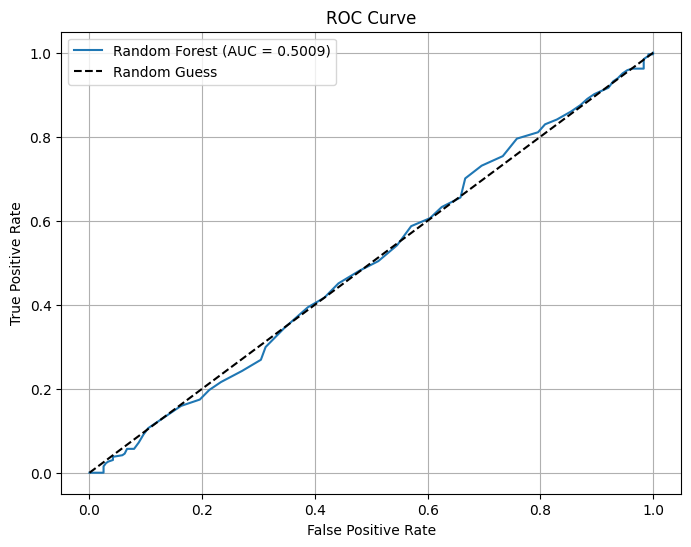

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute ROC AUC
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba_rf)
print(f"Random Forest AUC-ROC: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


Random Forest Precision-Recall AUC: 0.5133


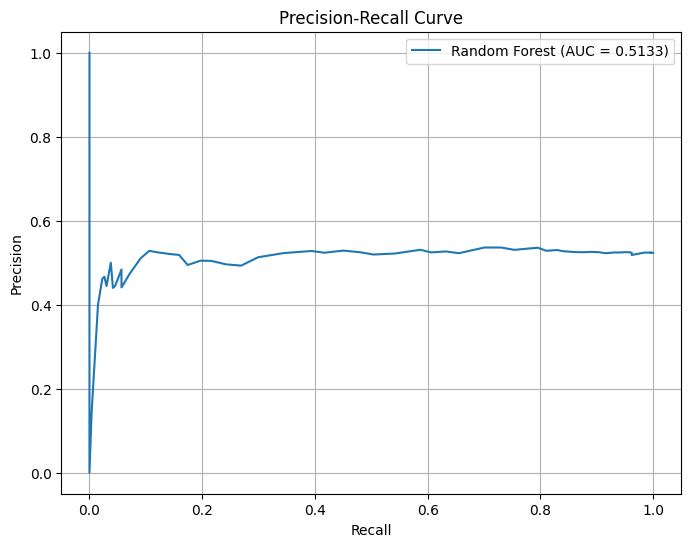

In [16]:
from sklearn.metrics import precision_recall_curve, auc

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_rf)
pr_auc = auc(recall, precision)
print(f"Random Forest Precision-Recall AUC: {pr_auc:.4f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Random Forest (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Train XGBoost Classifier
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)  # Remove use_label_encoder

xgb_model.fit(X_train_scaled, y_train)

# Make Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate XGBoost
print("\nXGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# Cross-Validation for XGBoost
cv_scores_xgb = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nAverage CV Accuracy (XGBoost): {np.mean(cv_scores_xgb):.4f}")



XGBoost Accuracy: 0.49206349206349204

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.46      0.41      0.44       240
           1       0.51      0.56      0.54       264

    accuracy                           0.49       504
   macro avg       0.49      0.49      0.49       504
weighted avg       0.49      0.49      0.49       504


Average CV Accuracy (XGBoost): 0.4943


In [18]:
from sklearn.svm import SVC

# Train SVM Classifier
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Make Predictions
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate SVM
print("\nSVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report (SVM):")
print(classification_report(y_test, y_pred_svm))

# Cross-Validation for SVM
cv_scores_svm = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nAverage CV Accuracy (SVM): {np.mean(cv_scores_svm):.4f}")



SVM Accuracy: 0.5198412698412699

Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.45      0.04      0.08       240
           1       0.52      0.95      0.68       264

    accuracy                           0.52       504
   macro avg       0.49      0.50      0.38       504
weighted avg       0.49      0.52      0.39       504


Average CV Accuracy (SVM): 0.5236


In [19]:
# from sklearn.model_selection import GridSearchCV

# # Define parameter grid
# param_grid_svm = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear', 'rbf'],
#     'gamma': [1, 0.1, 0.01, 0.001]
# }

# # Perform Grid Search
# grid_search_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=5, scoring='accuracy')
# grid_search_svm.fit(X_train_scaled, y_train)

# # Best parameters and score
# print("Best parameters for SVM:", grid_search_svm.best_params_)
# print("Best CV Accuracy for SVM:", grid_search_svm.best_score_)


In [20]:
# from sklearn.model_selection import GridSearchCV

# # Define parameter grid
# param_grid_xgb = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.8, 1.0]
# }

# # Perform Grid Search
# grid_search_xgb = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42), 
#                                param_grid_xgb, cv=5, scoring='accuracy')
# grid_search_xgb.fit(X_train_scaled, y_train)

# # Best parameters and score
# print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
# print("Best CV Accuracy for XGBoost:", grid_search_xgb.best_score_)


In [21]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize the base model for RFE (can also use RandomForestClassifier)
base_model = LogisticRegression(random_state=42)

# Apply RFE
rfe = RFE(estimator=base_model, n_features_to_select=3)  # Select top 3 features
rfe.fit(X_train_scaled, y_train)

# Get selected features
selected_features_rfe = X.columns[rfe.support_]
print("Selected Features (RFE):", selected_features_rfe)

# Train a model using only the selected features
X_train_rfe = X_train_scaled[:, rfe.support_]
X_test_rfe = X_test_scaled[:, rfe.support_]
base_model.fit(X_train_rfe, y_train)
y_pred_rfe = base_model.predict(X_test_rfe)

# Evaluate model performance
print("RFE Accuracy:", accuracy_score(y_test, y_pred_rfe))
print("RFE Classification Report:")
print(classification_report(y_test, y_pred_rfe))


Selected Features (RFE): Index(['Volume', 'Return', 'Momentum'], dtype='object')
RFE Accuracy: 0.5297619047619048
RFE Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.04      0.07       240
           1       0.53      0.98      0.69       264

    accuracy                           0.53       504
   macro avg       0.56      0.51      0.38       504
weighted avg       0.56      0.53      0.39       504



In [23]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize the base model for RFE (can also use RandomForestClassifier)
base_model = LogisticRegression(random_state=42)

# Apply RFE
rfe = RFE(estimator=base_model, n_features_to_select=3)  # Select top 3 features
rfe.fit(X_train_scaled, y_train)

# Get selected features
selected_features_rfe = X.columns[rfe.support_]
print("Selected Features (RFE):", selected_features_rfe)

# Train a model using only the selected features
X_train_rfe = X_train_scaled[:, rfe.support_]
X_test_rfe = X_test_scaled[:, rfe.support_]
base_model.fit(X_train_rfe, y_train)
y_pred_rfe = base_model.predict(X_test_rfe)

# Evaluate model performance
print("RFE Accuracy:", accuracy_score(y_test, y_pred_rfe))
print("RFE Classification Report:")
print(classification_report(y_test, y_pred_rfe))


Selected Features (RFE): Index(['Volume', 'Return', 'Momentum'], dtype='object')
RFE Accuracy: 0.5297619047619048
RFE Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.04      0.07       240
           1       0.53      0.98      0.69       264

    accuracy                           0.53       504
   macro avg       0.56      0.51      0.38       504
weighted avg       0.56      0.53      0.39       504



In [24]:
from sklearn.linear_model import LogisticRegressionCV

# Lasso-based feature selection using LogisticRegressionCV with L1 penalty
lasso_model = LogisticRegressionCV(cv=5, penalty='l1', solver='saga', random_state=42, max_iter=5000)
lasso_model.fit(X_train_scaled, y_train)

# Get selected features
selected_features_lasso = X.columns[lasso_model.coef_[0] != 0]
print("Selected Features (Lasso):", selected_features_lasso)

# Train and evaluate a model using only the selected features
X_train_lasso = X_train_scaled[:, lasso_model.coef_[0] != 0]
X_test_lasso = X_test_scaled[:, lasso_model.coef_[0] != 0]
lasso_model.fit(X_train_lasso, y_train)
y_pred_lasso = lasso_model.predict(X_test_lasso)

# Evaluate model performance
print("Lasso Accuracy:", accuracy_score(y_test, y_pred_lasso))
print("Lasso Classification Report:")
print(classification_report(y_test, y_pred_lasso))


Selected Features (Lasso): Index(['Volume', 'Return', 'Momentum'], dtype='object')
Lasso Accuracy: 0.5337301587301587
Lasso Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.04      0.07       240
           1       0.53      0.98      0.69       264

    accuracy                           0.53       504
   macro avg       0.61      0.51      0.38       504
weighted avg       0.61      0.53      0.39       504



In [25]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# Compute mutual information scores
mi_scores = mutual_info_classif(X_train_scaled, y_train)

# Select top k features
k = 3  # Number of top features to select
mi_selector = SelectKBest(mutual_info_classif, k=k)
X_train_mi = mi_selector.fit_transform(X_train_scaled, y_train)
X_test_mi = mi_selector.transform(X_test_scaled)

# Get selected features
selected_features_mi = X.columns[mi_selector.get_support()]
print("Selected Features (Mutual Information):", selected_features_mi)

# Train and evaluate a model using only the selected features
mi_model = LogisticRegression(random_state=42)
mi_model.fit(X_train_mi, y_train)
y_pred_mi = mi_model.predict(X_test_mi)

# Evaluate model performance
print("Mutual Information Accuracy:", accuracy_score(y_test, y_pred_mi))
print("Mutual Information Classification Report:")
print(classification_report(y_test, y_pred_mi))


Selected Features (Mutual Information): Index(['Volatility', '5Day_MA', 'Momentum'], dtype='object')
Mutual Information Accuracy: 0.5257936507936508
Mutual Information Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.05      0.10       240
           1       0.53      0.95      0.68       264

    accuracy                           0.53       504
   macro avg       0.52      0.50      0.39       504
weighted avg       0.52      0.53      0.40       504



In [22]:
# import pandas as pd
# from prophet import Prophet
# import matplotlib.pyplot as plt

# # Load stock data (ensure it has 'Date' and 'Close' columns)
# stock_data = pd.read_csv("sp500_stocks.csv")
# stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# # Prepare the data for Prophet
# df = stock_data[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# # Initialize and fit the Prophet model
# model = Prophet()
# model.fit(df)

# # Create a future dataframe (e.g., forecast for the next 30 days)
# future = model.make_future_dataframe(periods=30)
# forecast = model.predict(future)

# # Plot the forecast
# fig = model.plot(forecast)
# plt.title("Stock Price Forecast with Prophet")
# plt.show()

# # Plot forecast components (trend, seasonality, etc.)
# fig_components = model.plot_components(forecast)
# plt.show()